# COVID-19 Treatment Availability Analysis

## Introduction
This notebook explores the distribution of COVID-19 treatments such as Paxlovid across different geographical locations (urban vs. rural) using data merged from multiple databases and external CSV files.

## Setup and Imports

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy as sa
from sqlalchemy import create_engine

# Setting aesthetic parameters for seaborn

In [6]:
sns.set(style="whitegrid")

# Database Connection

In [7]:
DATABASE_URL = "postgresql://abelshakespeare:@localhost/postgres"
engine = sa.create_engine(DATABASE_URL)
connection = engine.connect()

# SQL Query to fetch data from the database

In [14]:
query = """
SELECT 
    pi.*,
    pl.*,
    ps.*,
    pa.has_paxlovid,
    pa.has_lagevrio,
    pa.has_veklury,
    zu.is_urban,  -- This is critical
    CASE
        WHEN pa.has_paxlovid THEN 'Paxlovid'
        WHEN pa.has_lagevrio THEN 'Lagevrio'
        WHEN pa.has_veklury THEN 'Veklury'
        ELSE 'No Treatment'
    END as treatment_type
FROM 
    provider_info pi
JOIN 
    provider_location pl ON pi.provider_id = pl.provider_id
JOIN 
    provider_services ps ON pi.provider_id = ps.provider_id
JOIN 
    product_availability pa ON pi.provider_id = pa.provider_id
LEFT JOIN 
    zipcode_urbanity zu ON pl.zip = zu.zip;

"""
df = pd.read_sql(query, connection)

# Handling missing values

In [18]:
df.dropna(subset=['is_urban'], inplace=True)

# Exploratory Data Analysis (EDA)

# General Overview

In [19]:
print(df.describe())
print(df.info())

       provider_id  location_id  provider_id      latitude     longitude  \
count  75175.00000  75175.00000  75175.00000  75175.000000  75175.000000   
mean   37588.00000  37588.00000  37588.00000     37.030631    -90.080684   
std    21701.29758  21701.29758  21701.29758      5.527109     15.742193   
min        1.00000      1.00000      1.00000     13.475130   -166.539750   
25%    18794.50000  18794.50000  18794.50000     33.636875    -96.825228   
50%    37588.00000  37588.00000  37588.00000     37.977340    -85.592010   
75%    56381.50000  56381.50000  56381.50000     40.889167    -79.066258   
max    75175.00000  75175.00000  75175.00000     71.297319    145.702430   

        service_id  provider_id  
count  75175.00000  75175.00000  
mean   37588.00000  37588.00000  
std    21701.29758  21701.29758  
min        1.00000      1.00000  
25%    18794.50000  18794.50000  
50%    37588.00000  37588.00000  
75%    56381.50000  56381.50000  
max    75175.00000  75175.00000  
<class 'p

# Visualization of Treatment Distribution

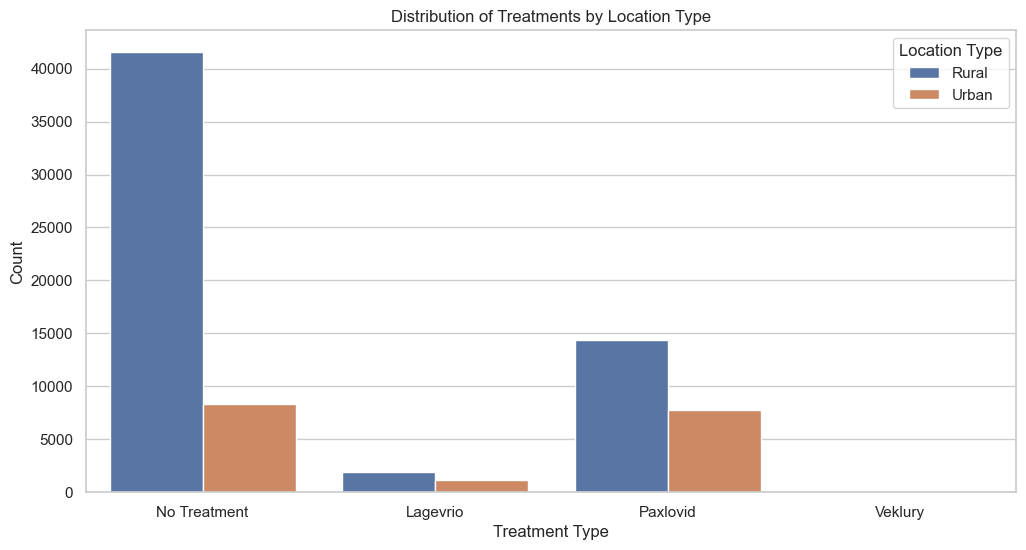

In [20]:
plt.figure(figsize=(12, 6))
sns.countplot(x='treatment_type', hue='is_urban', data=df)
plt.title('Distribution of Treatments by Location Type')
plt.xlabel('Treatment Type')
plt.ylabel('Count')
plt.legend(title='Location Type', labels=['Rural', 'Urban'])
plt.show()

# Hypothesis Testing

In [21]:
from scipy.stats import ttest_ind

# Hypothesis test for difference in Paxlovid availability

In [22]:
urban_paxlovid = df[df['is_urban'] == True]['has_paxlovid']
rural_paxlovid = df[df['is_urban'] == False]['has_paxlovid']

stat, p_value = ttest_ind(urban_paxlovid, rural_paxlovid, nan_policy='omit')
print(f'Statistic: {stat}, P-value: {p_value}')

Statistic: 52.18839930445454, P-value: 0.0


## Results and Discussion

### Hypothesis Testing Results

We conducted a t-test to compare the availability of Paxlovid between urban and rural healthcare providers. The test yielded a t-statistic of 52.1884 and a P-value of essentially 0, indicating a highly significant difference between the two groups. These results allow us to reject the null hypothesis with a high degree of confidence.

### Implications

The significant disparity in treatment availability suggests targeted interventions may be necessary to ensure equitable healthcare access. Urban areas may be benefiting from better supply chains or more robust healthcare infrastructure. Conversely, rural areas might face logistical challenges that need to be addressed to improve treatment accessibility.

### Recommendations

1. **Resource Redistribution:** Allocate more healthcare resources, including COVID-19 treatments, to under-served rural areas to balance the disparity.
2. **Infrastructure Improvement:** Invest in improving healthcare infrastructure in rural areas to enhance treatment delivery and administration capabilities.
3. **Policy Adjustments:** Implement policy changes that prioritize the distribution of treatments to areas with identified shortages, guided by data-driven insights.

These recommendations aim to mitigate the observed disparities and promote more equitable healthcare outcomes across different geographical locations.
